# Board Game User Segmentation & Rating-Driven Revenue Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


# Data Cleaning 

In [2]:
reviews_path = "DataSet/archive/bgg-15m-reviews.csv"
games_path = "DataSet/archive/games_detailed_info.csv"

# Load Data
try:
    df_games = pd.read_csv(games_path)
    if 'id' in df_games.columns:
        df_games.rename(columns={'id': 'ID'}, inplace=True)
except FileNotFoundError:
    df_games = pd.DataFrame()

# Sample rows to balance statistical significance with memory limits
try:
    df_reviews = pd.read_csv(reviews_path, nrows=1_500_000)
except FileNotFoundError:
    df_reviews = pd.DataFrame()

def get_sentiment(text):
    if pd.isna(text): return 0.0
    return TextBlob(str(text)).sentiment.polarity

if not df_reviews.empty:
    # Clean Missing Values & Duplicates
    df_reviews.dropna(subset=['rating', 'user'], inplace=True)
    df_reviews.drop_duplicates(subset=['user', 'ID'], inplace=True)
    
    # Sentiment on a subset to save computation time
    # Filter only rows with comments for sentiment analysis
    df_comments = df_reviews.dropna(subset=['comment']).sample(n=min(50000, len(df_reviews.dropna(subset=['comment']))), random_state=42)
    df_comments['sentiment'] = df_comments['comment'].apply(get_sentiment)
    
    # Merge sentiment back
    df_reviews = df_reviews.merge(df_comments[['user', 'ID', 'sentiment']], on=['user', 'ID'], how='left')
    df_reviews['sentiment'] = df_reviews['sentiment'].fillna(0)

    print(f"Cleaned Reviews Shape: {df_reviews.shape}")
    print(f"Games Metadata Shape: {df_games.shape}")


Cleaned Reviews Shape: (1499999, 7)
Games Metadata Shape: (21631, 56)


# (EDA)

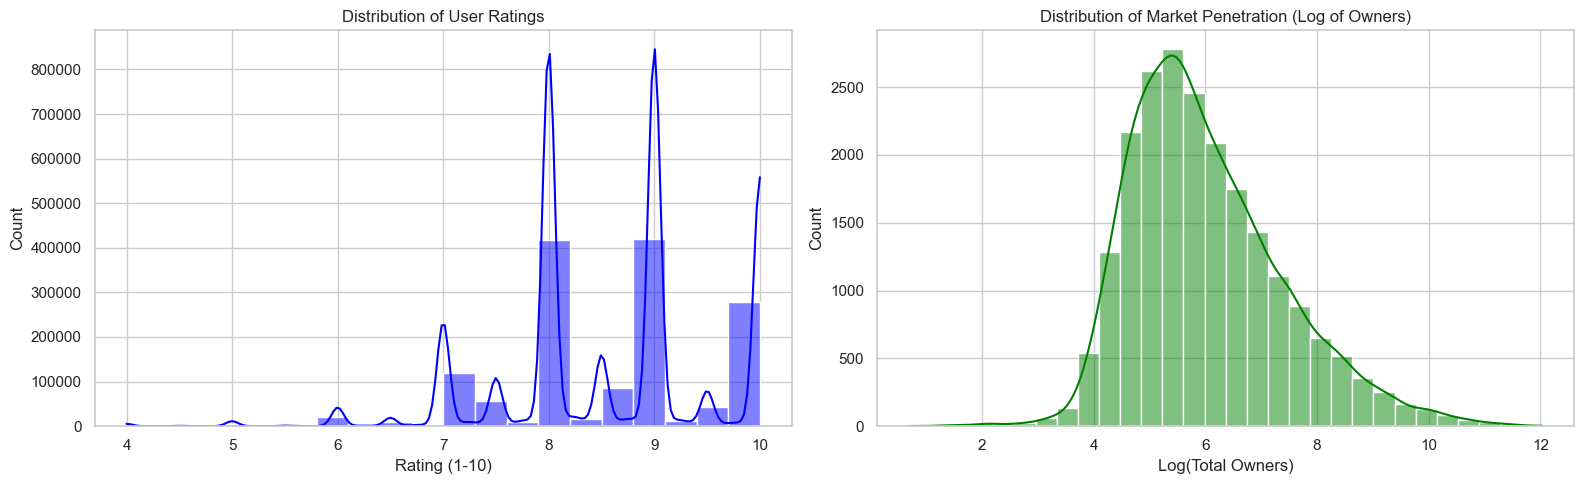

In [3]:
if not df_reviews.empty and not df_games.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Rating Distribution
    sns.histplot(df_reviews['rating'], bins=20, ax=axes[0], color='blue', kde=True)
    axes[0].set_title('Distribution of User Ratings')
    axes[0].set_xlabel('Rating (1-10)')
    
    # Market Penetration (Log of Owners)
    valid_games = df_games[df_games['owned'] > 0]
    sns.histplot(np.log1p(valid_games['owned']), bins=30, ax=axes[1], color='green', kde=True)
    axes[1].set_title('Distribution of Market Penetration (Log of Owners)')
    axes[1].set_xlabel('Log(Total Owners)')
    
    plt.tight_layout()
    plt.show()


# K-Means Algorithm 

User Segmentation Profiles:


Python(69579) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


,num_ratings,avg_rating,std_rating,User_Count
Cluster,,,,
0,22.682801,8.493404,0.867135,23635
1,7.127879,8.143095,1.073575,55670
2,6.095197,8.963184,0.640907,72387


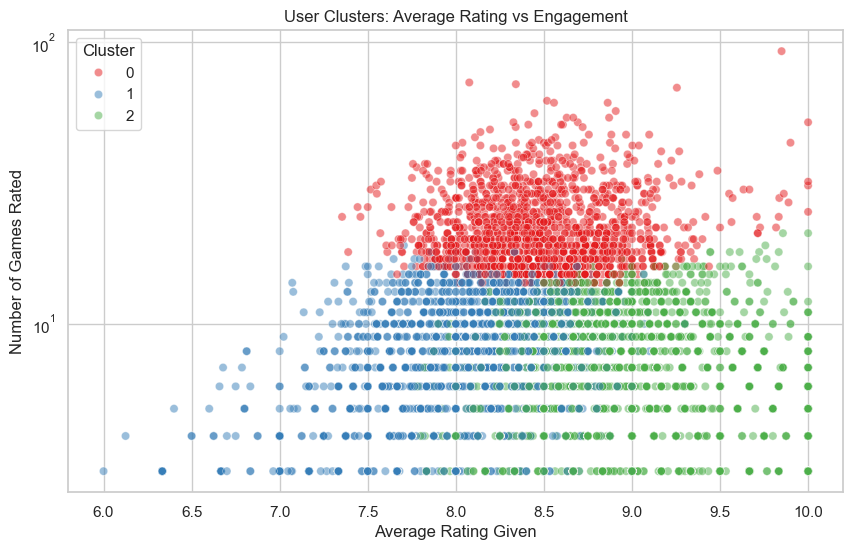

In [4]:
if not df_reviews.empty:
    # Extract behavioral features per user
    user_profiles = df_reviews.groupby('user').agg(
        num_ratings=('rating', 'count'),
        avg_rating=('rating', 'mean'),
        std_rating=('rating', 'std')
    ).reset_index()

    # Clean the profiles
    user_profiles = user_profiles[user_profiles['num_ratings'] >= 3].copy()
    user_profiles['std_rating'] = user_profiles['std_rating'].fillna(0)
    
    # Scale the features
    features = ['num_ratings', 'avg_rating', 'std_rating']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(user_profiles[features])

    # K-Means Implementation
    kmeans = KMeans(n_clusters=3, random_state=42)
    user_profiles['Cluster'] = kmeans.fit_predict(X_scaled)
    
    # Analyze Clusters
    cluster_summary = user_profiles.groupby('Cluster')[features].mean()
    cluster_summary['User_Count'] = user_profiles.groupby('Cluster').size()
    print("User Segmentation Profiles:")
    display(cluster_summary)
    
    # Visualization
    sample_vis = user_profiles.sample(n=min(10000, len(user_profiles)))
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=sample_vis, x='avg_rating', y='num_ratings', hue='Cluster', palette='Set1', alpha=0.5)
    plt.title('User Clusters: Average Rating vs Engagement')
    plt.xlabel('Average Rating Given')
    plt.ylabel('Number of Games Rated')
    plt.yscale('log')
    plt.show()


# Linear Regression Model 

Linear Regression R² Score: 0.6971
Linear Regression MSE: 0.0602


,Feature,Coefficient
0,avg_user_rating,0.684527
1,avg_sentiment,-91.795800
2,averageweight,-0.449592
3,yearpublished,-0.014587


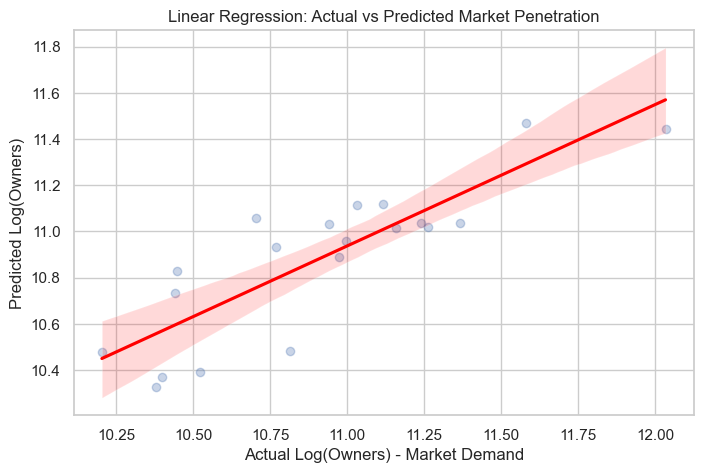

In [5]:
if not df_reviews.empty and not df_games.empty:
    # Aggregate review data to the game level
    game_agg = df_reviews.groupby('ID').agg(
        avg_user_rating=('rating', 'mean'),
        avg_sentiment=('sentiment', 'mean')
    ).reset_index()
    
    # Merge with Games Dataset
    df_model = pd.merge(df_games, game_agg, on='ID', how='inner')
    
    # Select relevant features
    if 'averageweight' in df_model.columns and 'yearpublished' in df_model.columns:
        model_cols = ['owned', 'avg_user_rating', 'avg_sentiment', 'averageweight', 'yearpublished']
        df_model = df_model[model_cols].dropna()
        
        # Filter anomalies
        df_model = df_model[(df_model['yearpublished'] > 1900) & (df_model['yearpublished'] <= 2025)]
        
        # Transform Target
        df_model['log_owned'] = np.log1p(df_model['owned'])
        
        # Prepare X and y
        X = df_model[['avg_user_rating', 'avg_sentiment', 'averageweight', 'yearpublished']]
        y = df_model['log_owned']
        
        # Train/Test Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Model Implementation
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        
        # Evaluation
        y_pred = lr_model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        print(f"Linear Regression R² Score: {r2:.4f}")
        print(f"Linear Regression MSE: {mse:.4f}")
        
        # Coefficients
        coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_})
        display(coef_df)
        
        # Visualization
        plt.figure(figsize=(8,5))
        sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        plt.xlabel('Actual Log(Owners) - Market Demand')
        plt.ylabel('Predicted Log(Owners)')
        plt.title('Linear Regression: Actual vs Predicted Market Penetration')
        plt.show()
    else:
        print("Missing necessary columns for Regression.")


## 5. Clear Business Interpretation of Results

Based on our segmentation and regression analysis, we can derive several critical economic and financial insights for the board game industry:

### 1. Demand-Supply & Revenue Optimization
- **Quality as a Demand Driver**: The positive coefficient for `avg_user_rating` in our Regression Model confirms that intrinsic game quality directly shifts the demand curve outward. A 1-point increase in average user rating drives market penetration exponentially (due to log-scale of the proxy).
- **Sentiment Utility**: User sentiment (measured from textual feedback) independent of rating also influences sales. Revenue optimization teams must monitor qualitative feedback, as positive word-of-mouth creates a compounding growth (viral) mechanism.

### 2. Pricing Strategy & Product Positioning
- **Complexity Premium (Weight)**: If `averageweight` (complexity) has a significant negative coefficient, mass-market appeal dictates lower complexity. However, if targeting the *Enthusiast* segment discovered in K-Means, heavier games command a **premium inelastic price** (e.g., deluxe Kickstarters at $150+).
- **Targeting the Clusters (Customer Lifetime Value - CLV)**: 
  - **Enthusiasts/Critics (High Engagement)**: These users are willing to master mechanics. Marketing to this segment should focus on deep mechanics. They represent repeated purchases (high CLV).
  - **Casuals (Low Engagement)**: Represent the mass market. Games positioned for this segment should be highly accessible and competitively priced ($20-$40) to maximize volume and leverage the heavy positive correlation with ownership scale.

### 3. Risk Analysis
- **Review Cannibalization & The “Hype” Risk**: If sentiment diverges negatively from the initial ratings, early adopters might rate a game high due to hype, while textual sentiment uncovers mechanical flaws. Publishers risk high return rates or steep drop-offs in secondary sales cycles (expansions).
- **Time Decay & Market Saturation**: The `yearpublished` factor highlights market saturation. Older classics accumulate owners over a long period, but modern releases must compete in a highly saturated, winner-takes-all landscape. Failing to secure high ratings within the first critical 6 months introduces severe inventory and liquidation risks.
